In [2]:
import torch
import numpy as np
import random

random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
!pwd

/data/notebook/competition/cv-12/EDA


In [4]:
train_dir_path = '../../input/data/train/'
train_csv_path = train_dir_path + 'train.csv'

----

In [5]:
import pandas as pd
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

id  gender   race  age                    path
0  1  female  Asian   45  000001_female_Asian_45
1  2  female  Asian   52  000002_female_Asian_52
2  4    male  Asian   54    000004_male_Asian_54
3  5  female  Asian   58  000005_female_Asian_58
4  6  female  Asian   59  000006_female_Asian_59

----

In [9]:
import os
import matplotlib.pyplot as plt
import cv2

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield os.path.join(path, file)

train_samples = train_csv.sample(50)
def show_photos(person_id):
    plt.figure(figsize=(20,20))
    columns = 7
    files = list(get_files(train_dir_path + f"images/{train_samples.iloc[person_id]['path']}/"))
    i = 0
    for filepath in files:
        _, file_extension = os.path.splitext(filepath)
        if file_extension not in ['.jpg', '.jpeg', '.png']:
            continue
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(files) // columns + 1, columns, i + 1)
        plt.imshow(img)
        i += 1

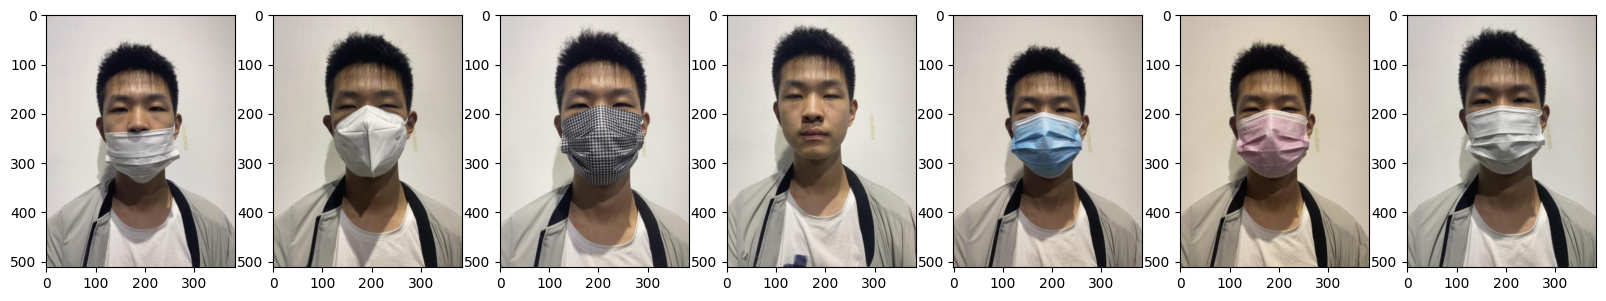

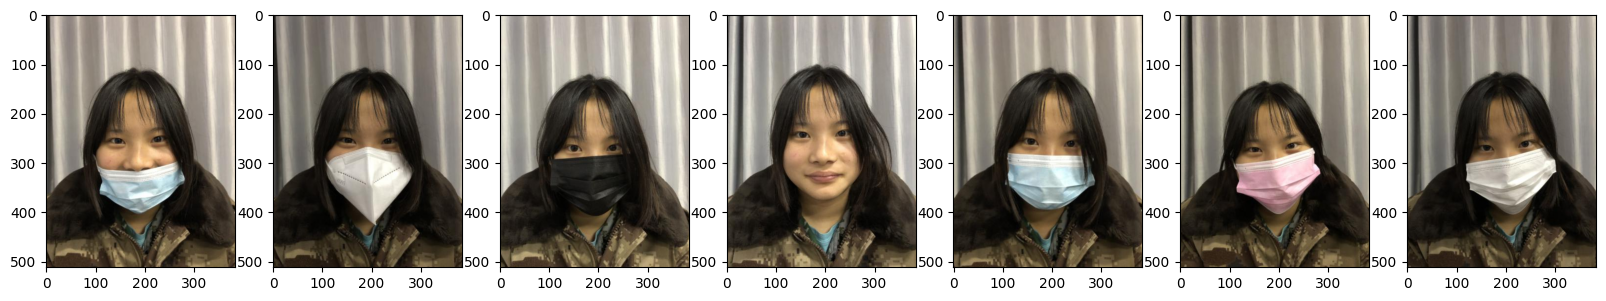

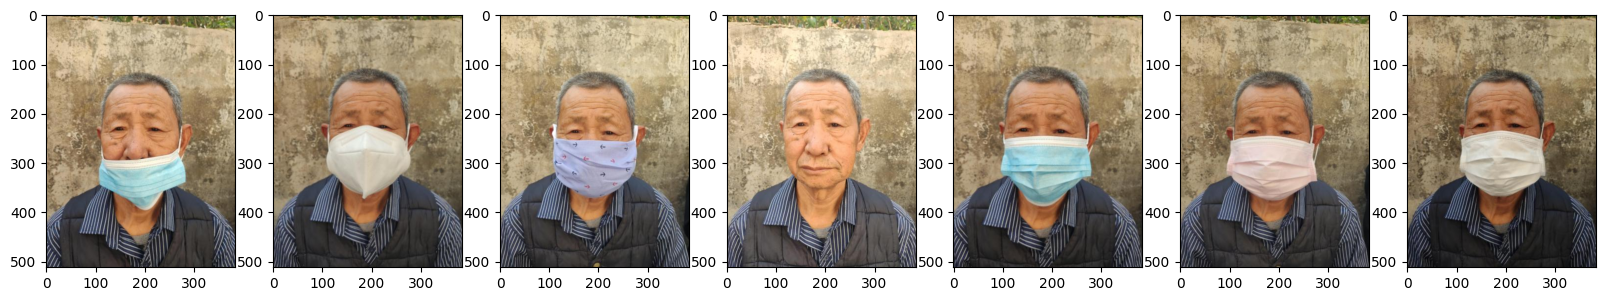

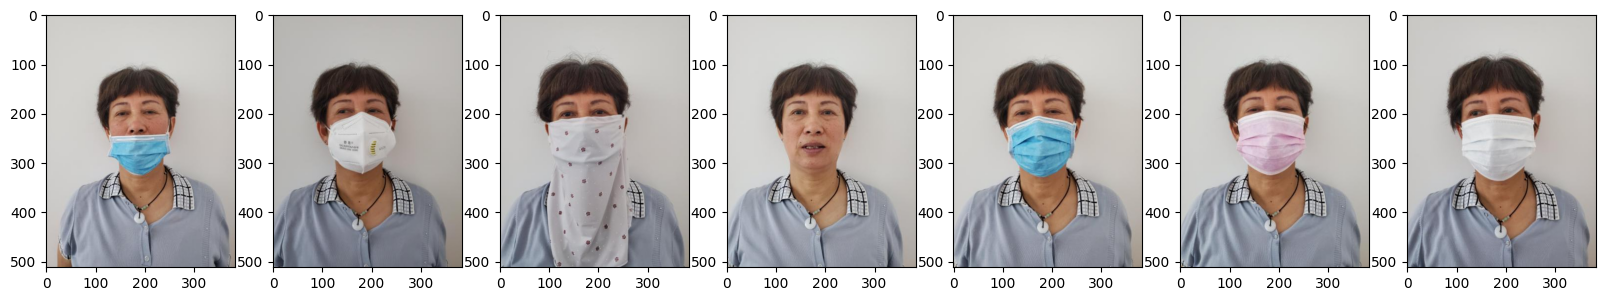

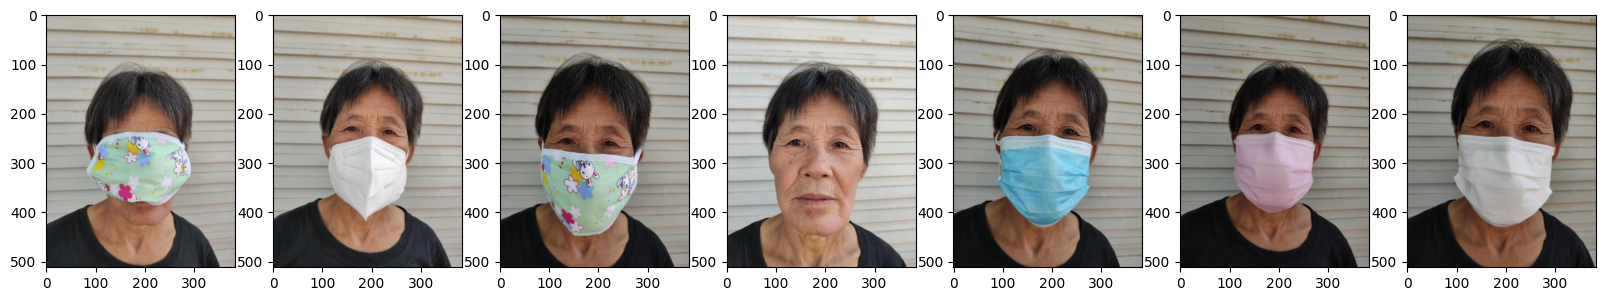

In [10]:
for i in range(5):
    show_photos(i)

----

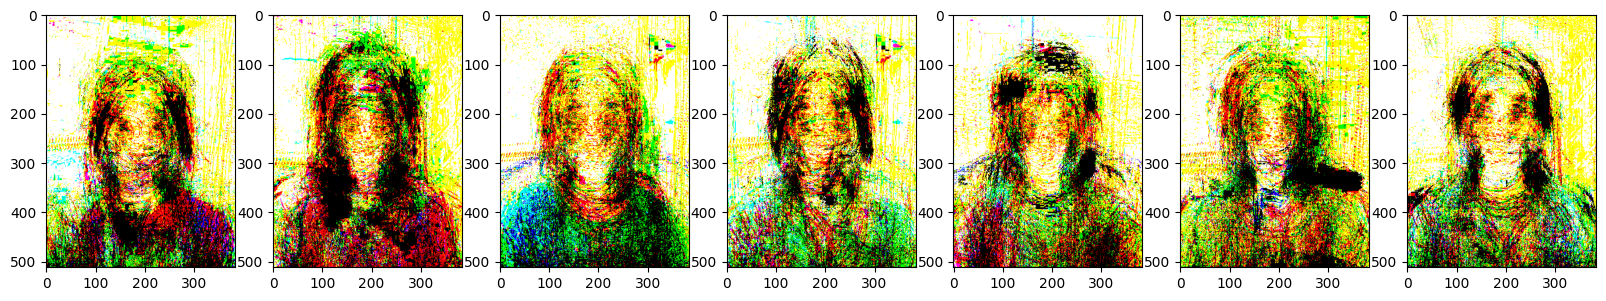

In [59]:
import os
import matplotlib.pyplot as plt
import cv2

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield os.path.join(path, file)

def blending_photos(blending_size):
    plt.figure(figsize=(20,12))
    columns = 7
    for col in range(columns):
        train_shuffles = train_csv.sample(blending_size)
        target_img = None
        for pid, person_id in enumerate(range(len(train_shuffles))):
            files = list(get_files(train_dir_path + f"images/{train_shuffles.iloc[person_id]['path']}/"))
            idx = 0
            for filepath in files:
                _, file_extension = os.path.splitext(filepath)
                if file_extension not in ['.jpg', '.jpeg', '.png']:
                    continue
                source_img = cv2.imread(filepath)
                source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
                if target_img is None:
                    target_img = source_img
                    continue
                source_weight = 1 / (pid + 1)
                target_weight = 1 - source_weight
                #target_img = cv2.addWeighted(target_img, target_weight, source_img, source_weight, 0)
                target_img = cv2.multiply(target_img, source_img)
                idx += 1
        plt.subplot(1, columns, col + 1)
        plt.imshow(target_img)

blending_photos(200) # 20명씩 blending * 7패턴

In [30]:
import os
import pandas as pd

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield os.path.join(path, file)

new_train_csv = pd.DataFrame(columns = ['PersonID',   # 000001 ~ 
                                        'Path',       # Image Path
                                        'Class',      # 0 ~ 17
                                        'Mask',       # 0 ~ 2 / M, m, _
                                        'Gender',     # 0 ~ 1 / M, F
                                        'Age_Class',  # 0 ~ 2 / <30, ~45~, 60<
                                        ])

train_image_path = '../../input/data/crop_train/'
train_image_files = list(get_files(train_image_path))

for filepath in train_image_files:
    file_name, file_extension = os.path.splitext(os.path.basename(filepath))

    if file_extension in ['.jpg', '.jpeg', '.png']:
        parse     = file_name.split("-")
        gender    = 0 if parse[3] == "MM" else 1
        mask      = 2 if parse[2] == "OK" else (1 if parse[2] == "IC" else 0)
        age_class = 0 if parse[4] == "YA" else (2 if parse[4] == "OA" else 1)
        encode_class = age_class + (gender * 3) + (mask * 6)

        new_train_csv.loc[len(new_train_csv)] = [parse[1],
                                                 filepath,
                                                 encode_class,
                                                 mask,
                                                 gender,
                                                 age_class
                                                ]

print(new_train_csv.head())

  PersonID                                               Path  Class  Mask  \
0     6622  ../../input/data/crop_train/18075-6622-NO-MM-Y...      0     0   
1     1587  ../../input/data/crop_train/5898-1587-OK-FF-YA...     15     2   
2     4216  ../../input/data/crop_train/12397-4216-NO-FF-M...      4     0   
3     1659  ../../input/data/crop_train/6336-1659-IC-MM-YA...      6     1   
4     4218  ../../input/data/crop_train/12406-4218-NO-FF-O...      5     0   

   Gender  Age_Class  
0       0          0  
1       1          0  
2       1          1  
3       0          0  
4       1          2  


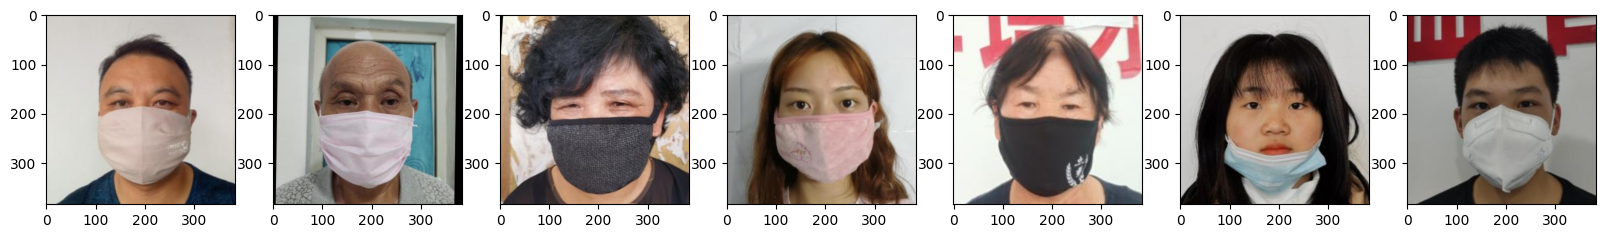

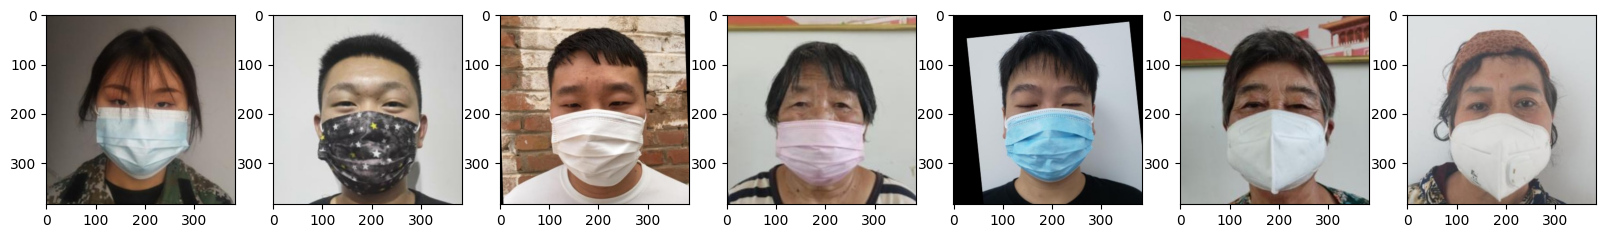

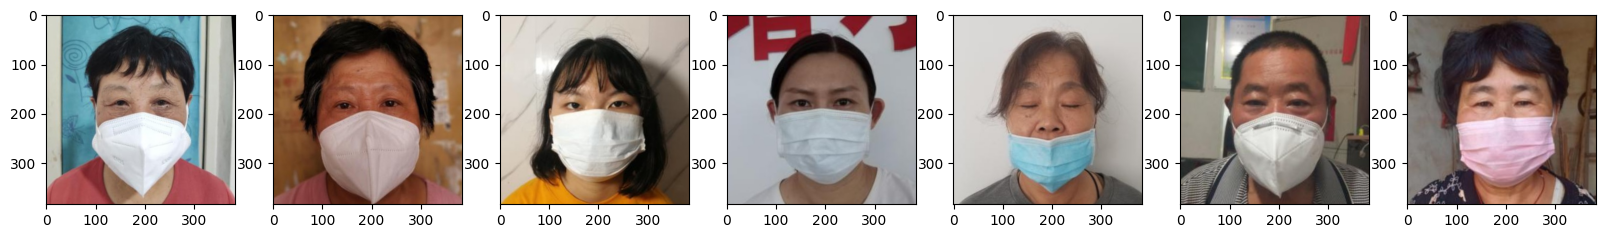

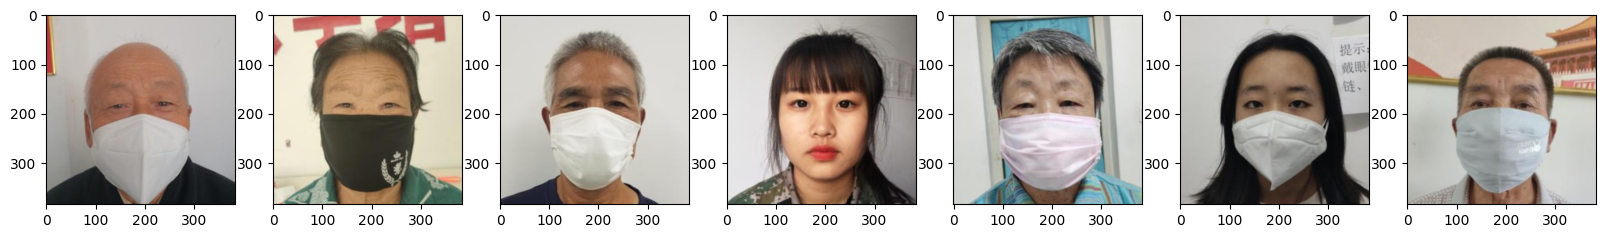

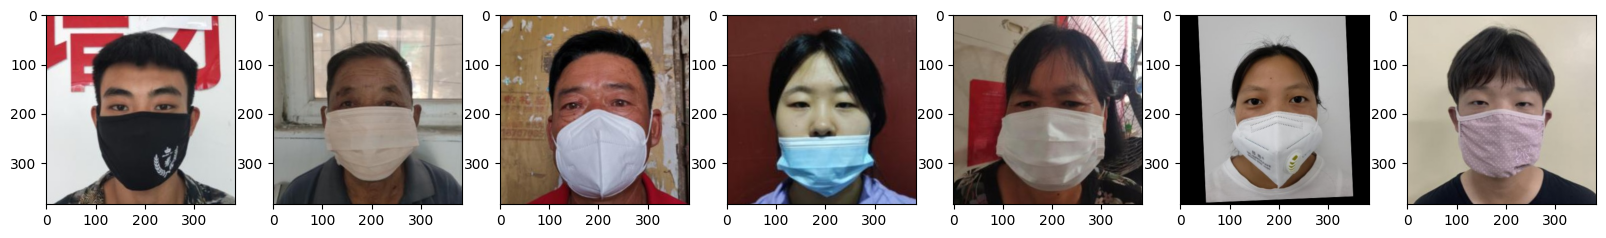

In [40]:
def crop_show_photos(person_id):
    plt.figure(figsize=(20,20))
    columns = 7
    idx = 0
    new_train_samples = new_train_csv.sample(7)
    for person_id in range(len(new_train_samples)):
        img = cv2.imread(new_train_samples.iloc[person_id]['Path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, columns, idx + 1)
        plt.imshow(img)
        idx += 1

for i in range(5):
    crop_show_photos(i)

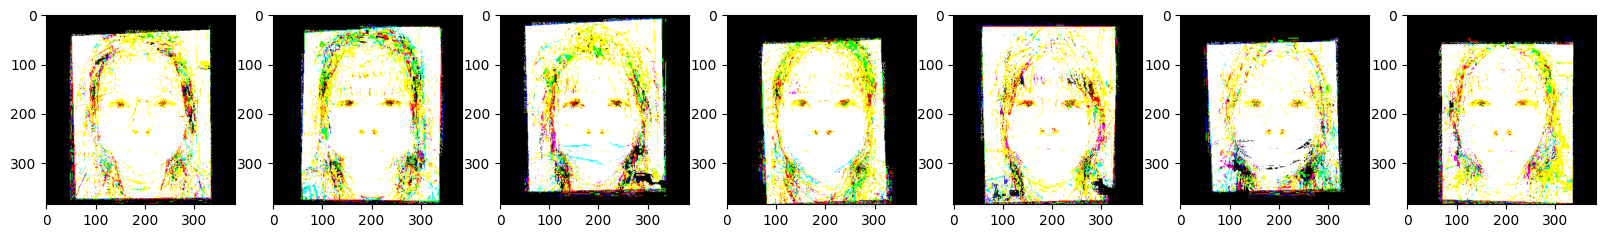

In [63]:
def crop_blending_photos(blending_size):
    plt.figure(figsize=(20,12))
    columns = 7
    for col in range(columns):
        new_train_samples = new_train_csv.sample(blending_size)
        target_img = None
        idx = 0
        for pid, person_id in enumerate(range(len(new_train_samples))):
            source_img = cv2.imread(new_train_samples.iloc[person_id]['Path'])
            source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
            if target_img is None:
                target_img = source_img
                continue
            source_weight = 1 / (pid + 1)
            target_weight = 1 - source_weight
            #target_img = cv2.addWeighted(target_img, target_weight, source_img, source_weight, 0)
            target_img = cv2.multiply(target_img, source_img)
            idx += 1
        plt.subplot(1, columns, col + 1)
        plt.imshow(target_img)

crop_blending_photos(200)

----
Submission checker
----

In [6]:
eval_dir_path = '../../../test/input/data/eval/'
submissions_csv_path = eval_dir_path + 'submission_detect_crop_3.csv'

In [9]:
import pandas as pd
submissions_csv = pd.read_csv(submissions_csv_path)
output_samples = submissions_csv.sample(7)
output_samples.head()

ImageID  ans
11309  4d235c91cb557622baf554c13a4ea040b2f2416e.jpg    3
2168   f272c28662d45ce1529cf521f898d7d972c6da2f.jpg    4
2612   0e682f18443b43c426e064c354b3c59d75d6b42b.jpg    4
12086  4c17a6a766a470a99c328a65ae047833d1ae8c58.jpg    9
6494   d877ec6f1956cab2362c79b242ae0f04d2d074dc.jpg    3

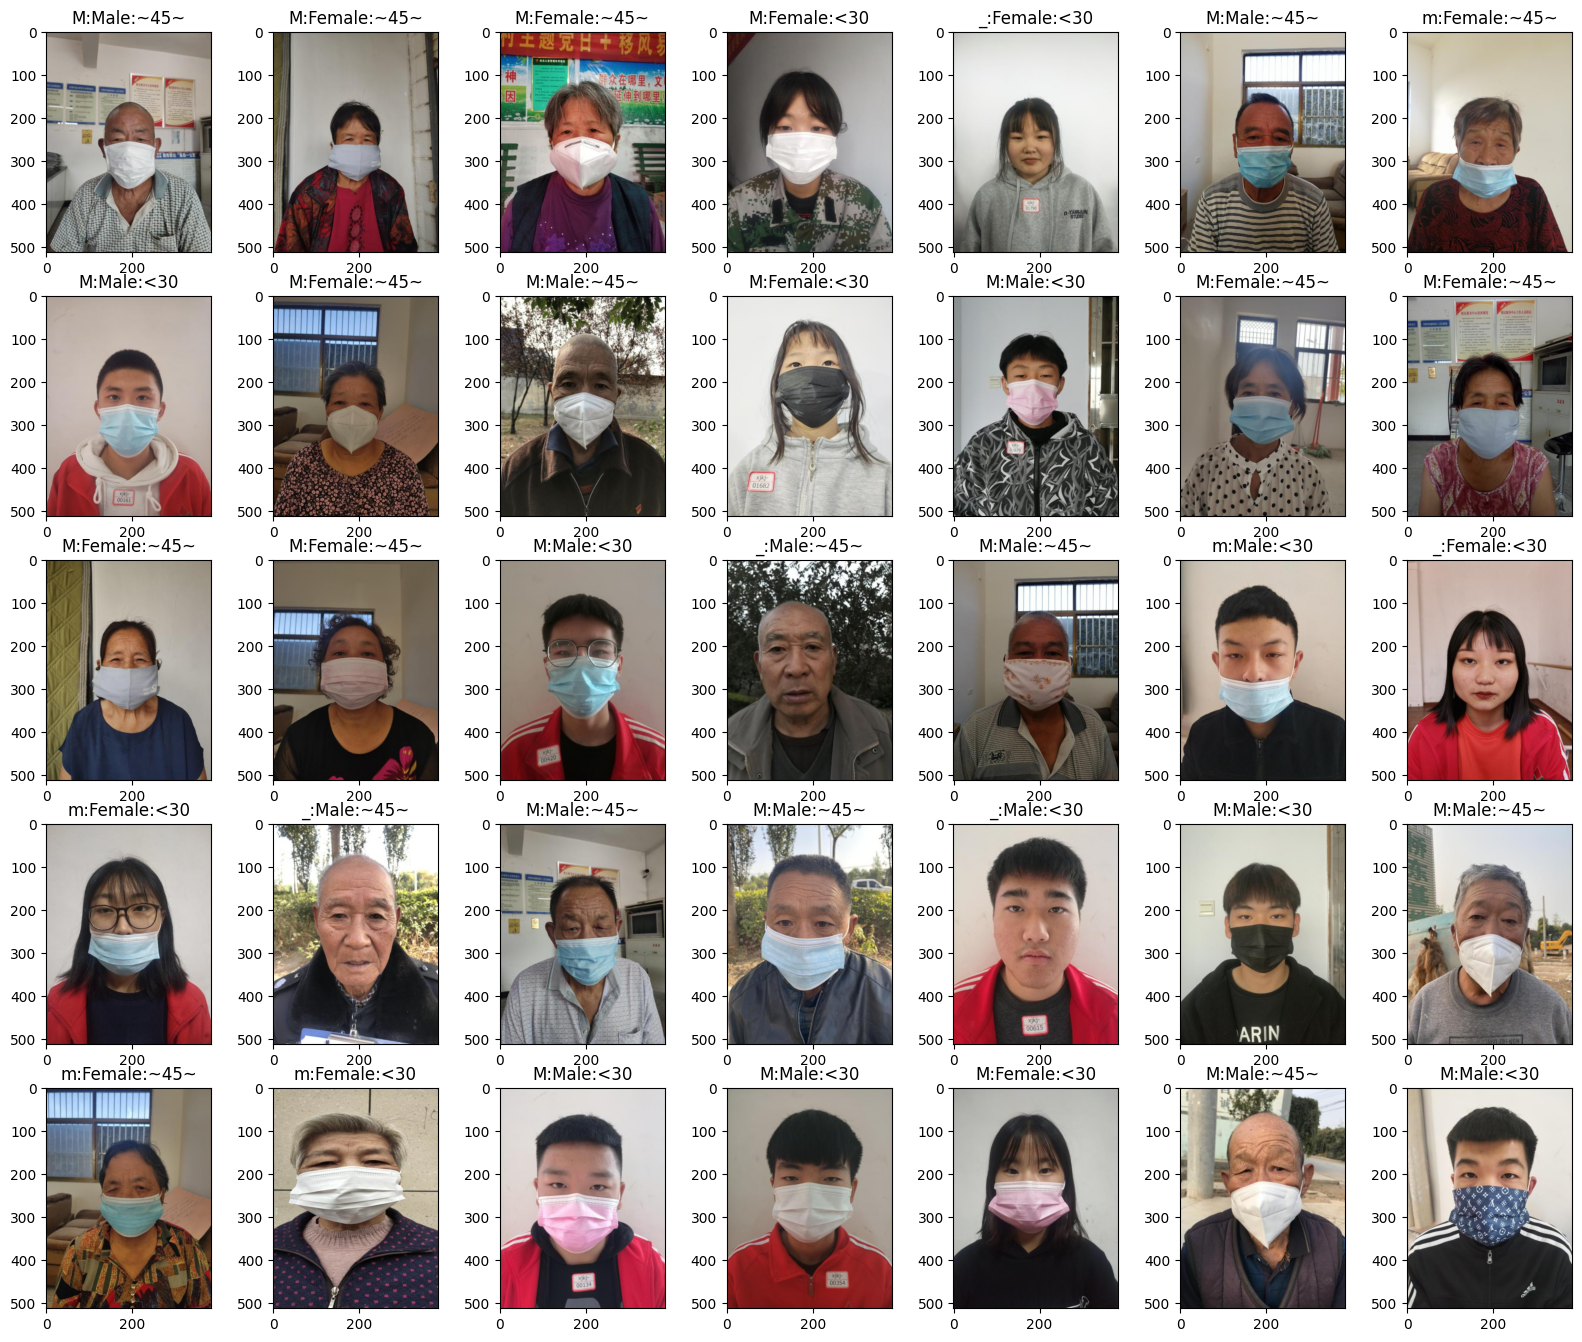

In [11]:
import os
import matplotlib.pyplot as plt
import cv2

def show_result(df):
    classname = ['M:Male:<30','M:Male:~45~','M:Male:<60',
                 'M:Female:<30','M:Female:~45~','M:Female:<60',
                 'm:Male:<30','m:Male:~45~','m:Male:<60',
                 'm:Female:<30','m:Female:~45~','m:Female:<60',
                 '_:Male:<30','_:Male:~45~','_:Male:<60',
                 '_:Female:<30','_:Female:~45~','_:Female:<60']
    plt.figure(figsize=(20, 20))
    columns = 7
    person_len = len(df)
    for person_id in range(person_len):
        filename = eval_dir_path + f"images/{df.iloc[person_id]['ImageID']}"
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(person_len // columns + 1, columns, person_id + 1)
        plt.imshow(img)
        plt.gca().set_title(classname[df.iloc[person_id]['ans']])

output_samples = submissions_csv.sample(5 * 7)
show_result(output_samples)